In [1]:
import os
import torch
import torch.nn as nn
from floortrans.models import get_model

In [99]:
def get_best_checkpoint(arch, weights, resume_epoch=True, device='cpu', n_classes=44):
    input_slice = [21, 12, 11]
    if arch == 'hg_furukawa_original':
        model = get_model(arch, 51, device=device)
        # if furukawa_weights:
        #     logger.info("Loading furukawa model weights from checkpoint '{}'".format(furukawa_weights))
        #     checkpoint = torch.load(furukawa_weights)
        #     model.load_state_dict(checkpoint['model_state'])

        model.conv4_ = nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
        model.upsample = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
        for m in [model.conv4_, model.upsample]:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            nn.init.constant_(m.bias, 0)
    else:
        model = get_model(arch, n_classes, device=device)

    checkpoint = torch.load(weights, map_location=device)
    return checkpoint['epoch']

In [100]:
best_checkpoint = {}

best_checkpoint['Deeplabv3'] = get_best_checkpoint('deeplabv3', './runs_cubi/resume/deeplabv3/model_best_val_loss_var.pkl')
best_checkpoint['Deeplabv3']

In [101]:
best_checkpoint['DFP-VGG16'] = get_best_checkpoint('dfp', './runs_cubi/resume/dfp/model_best_val_loss_var.pkl')
best_checkpoint['DFP-VGG16']

403

In [102]:
best_checkpoint['DFP-ResNet34'] = get_best_checkpoint('dfp-resnet34-encoder-conv', './runs_cubi/resume/dfp-resnet34-encoder-conv/model_best_val_loss_var.pkl')
best_checkpoint['DFP-ResNet34']


221

In [103]:
best_checkpoint['DFP-ResNet50'] = get_best_checkpoint('dfp-resnet50-encoder-conv', './runs_cubi/resume/dfp-resnet50-encoder-conv/model_best_val_loss_var.pkl')
best_checkpoint['DFP-ResNet50']

350

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

In [2]:
path = './runs_cubi_csv/total_loss'
series = {}

for file in os.listdir(path):
    df = pd.read_csv(f'{path}/{file}')
    model = file.split('_')[1]

    if model not in series: series[model] = []
    series[model].append(df)

one = list(series.keys())[0]
ex = series[one]
ex

[        Wall time  Step     Value
 0    1.663333e+09    96  0.894876
 1    1.663333e+09    97  0.909633
 2    1.663333e+09    98  0.887142
 3    1.663334e+09    99  0.845862
 4    1.663334e+09   100  0.908983
 ..            ...   ...       ...
 200  1.663399e+09   296  0.688690
 201  1.663399e+09   297  0.700769
 202  1.663400e+09   298  0.696880
 203  1.663400e+09   299  0.701566
 204  1.663400e+09   300  0.704040
 
 [205 rows x 3 columns],
         Wall time  Step     Value
 0    1.663556e+09   221  0.685272
 1    1.663556e+09   222  0.688209
 2    1.663557e+09   223  0.701488
 3    1.663557e+09   224  0.700400
 4    1.663557e+09   225  0.689700
 ..            ...   ...       ...
 275  1.663645e+09   496  0.683088
 276  1.663645e+09   497  0.681809
 277  1.663645e+09   498  0.688563
 278  1.663646e+09   499  0.697146
 279  1.663646e+09   500  0.711350
 
 [280 rows x 3 columns],
        Wall time  Step     Value
 0   1.663258e+09     1  1.798509
 1   1.663259e+09     2  1.632282
 2  

In [3]:
def plot_logs(path, ylim=None):
    series = {}

    for file in os.listdir(path):
        df = pd.read_csv(f'{path}/{file}')
        model = file.split('_')[1]

        if model not in series: series[model] = {'dfs': []}
        series[model]['dfs'].append(df)

        if 'run-resume' in file and 'old' not in file:
            best = df.nsmallest(1, 'Value')
            series[model]['best'] = (best.Step, best.Value)

    colors = sns.color_palette()
    plt.figure(figsize=(16,10))

    model_names = ('Deeplabv3', 'DFP-VGG16', 'DFP-ResNet34', 'DFP-ResNet50')
    models = sorted(series.keys())
    models[1], models[2], models[3] = models[3], models[1], models[2] # swap to appear in model_names order

    for i, model in enumerate(models):
        model_name = model[:model.index('tag')]
        for j, part in enumerate(series[model]['dfs']):
            sns.lineplot(x=part.Step, y=part.Value, color=colors[i])
            # sns.lineplot(x=part.Step, y=part.Value, color=colors[i], label=model_names[i] if j == 0 else '')
    
    for i, model in enumerate(models):
        sns.scatterplot(x=series[model]['best'][0], y=series[model]['best'][1], color=colors[i], label=model_names[i])

    plt.legend()
    plt.ylabel('Loss value')
    plt.xlabel('Epoch')
    if ylim:
        plt.ylim(ylim)
    plt.show()

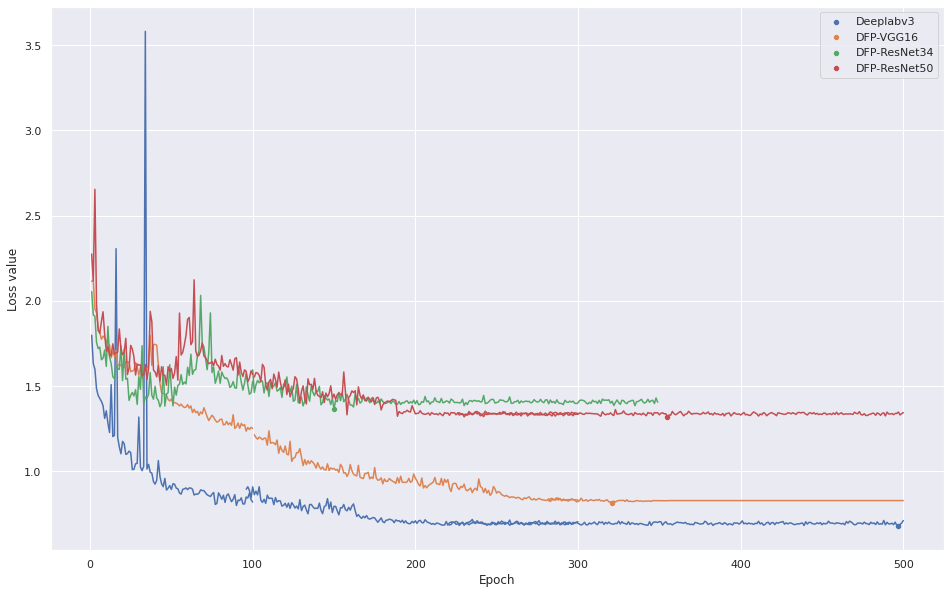

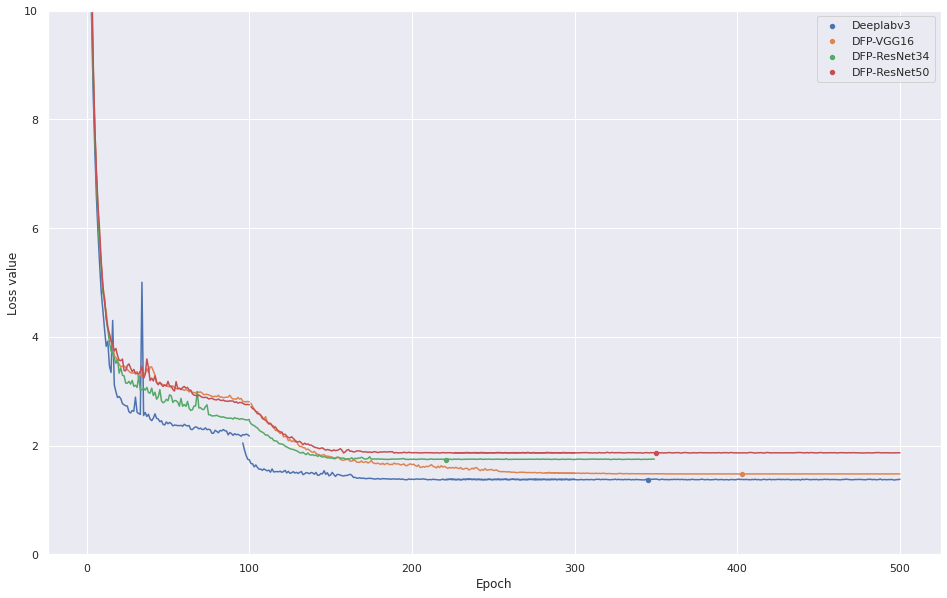

In [4]:
plot_logs('./runs_cubi_csv/total_loss')
plot_logs('./runs_cubi_csv/weighted_loss', ylim=[0, 10])

In [46]:
def criteria(x):
    if 'with-scale' in x['file']:
        return 0
    if 'old' in x['file']:
        return 1
    return 2

def plot_logs_concat(path, ylim=None, save_file=None):
    series = {}

    for file in os.listdir(path):
        if '.pdf' in file:
            continue

        df = pd.read_csv(f'{path}/{file}')
        model = file.split('_')[1]

        if model not in series: series[model] = {'dfs': []}
        series[model]['dfs'].append({'df': df, 'file': file})

        if 'run-resume' in file and 'old' not in file:
            best = df.nsmallest(1, 'Value')
            series[model]['best'] = (best.Step, best.Value)

    for model in series:
        dfs = [df['df'] for df in sorted(series[model]['dfs'], key=criteria)]

        for i in range(len(dfs)-1):
            dfs[i] = dfs[i][dfs[i].Step < dfs[i+1].Step.min()]
        series[model]['dfs'] = pd.concat(dfs, ignore_index=True)

    colors = sns.color_palette()
    plt.figure(figsize=(15,13))

    model_names = ('Deeplabv3', 'DFP-VGG16', 'DFP-ResNet34', 'DFP-ResNet50')
    models = sorted(series.keys())
    models[1], models[2], models[3] = models[3], models[1], models[2] # swap to appear in model_names order

    for i, model in enumerate(models):
            model_name = model[:model.index('tag')]
            df = series[model]['dfs']
            sns.lineplot(x=df.Step, y=df.Value, color=colors[i])
        
    for i, model in enumerate(models):
        sns.scatterplot(x=series[model]['best'][0], y=series[model]['best'][1], color=colors[i], label=model_names[i], s=240)

    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    if ylim:
        plt.ylim(ylim)
    if save_file:
        plt.savefig(path+'/'+save_file, bbox_inches='tight')
    plt.show()


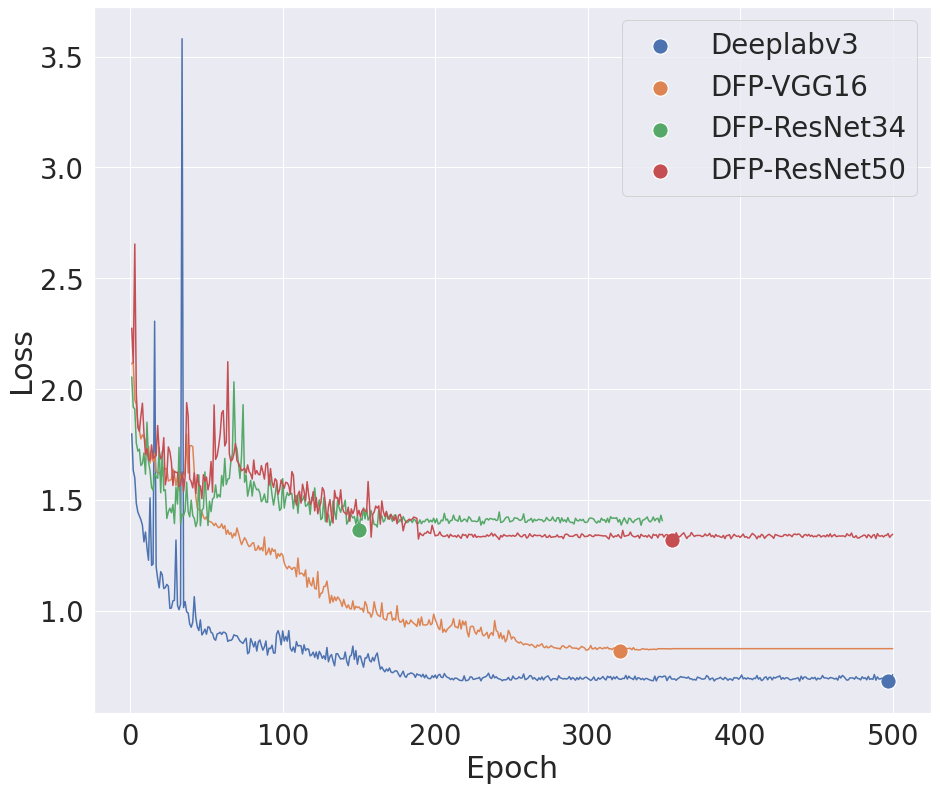

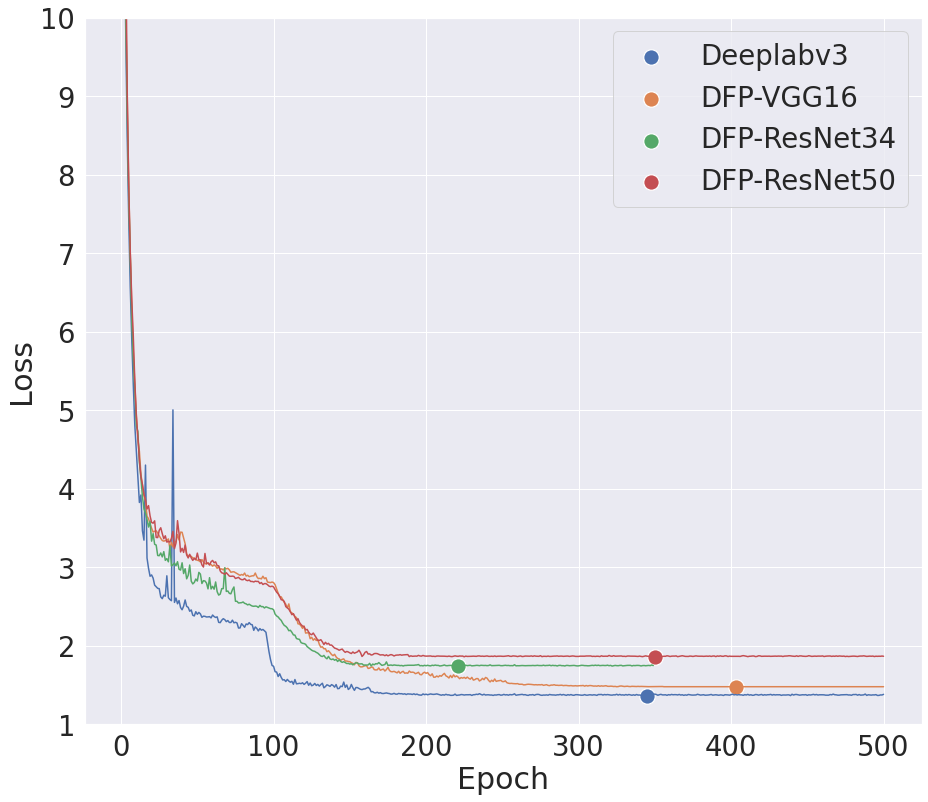

In [48]:
sns.set(font_scale=2.5)

plot_logs_concat('./runs_cubi_csv/total_loss', save_file='validation-curve-unweighted.pdf')
plot_logs_concat('./runs_cubi_csv/weighted_loss', save_file='validation-curve-weighted.pdf', ylim=[1, 10])